In [9]:
# load packages and data
library(data.table) 
library(ggplot2)
library(dplyr) # if not installed locally, in command prompt use "conda install -c r r-dplyr"
library(tidyr)

# change deafult plot sizes
options(repr.plot.width=4, repr.plot.height=3)

# load data
loadDir = './Data/' # set directory where data will be loaded from
loadFName = 'Make 18_full.csv' # set file name of Qualtrics csv
rawData <- data.table::fread(input = paste(loadDir, loadFName, sep=''))

# also load in data from AMT to match MIDs (to download: on AMT site > Review Results > Download CSV)
amtIDs = data.table::fread(input = paste(loadDir, 'Make 18_full_AMT.csv' , sep=''), select='WorkerId') 

dataStartRow = 75 # set the row number when full experiment starts (used to exclude MIDs from past pilot runs)


Warning message in data.table::fread(input = paste(loadDir, "Make 18_full_AMT.csv", :
"Detected 30 column names but the data has 28 columns. Filling rows automatically. Set fill=TRUE explicitly to avoid this warning."

In [3]:
head(rawData)

StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,q1_txt,q2_txt,q3_txt,q4_txt,q5_txt,surveycode,MID,p1_txt,p2_txt,Random
Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,q1_txt,q2_txt,q3_txt,q4_txt,q5_txt,surveycode,MID,p1_txt,p2_txt,Random
"{""""ImportId"""":""""startDate"""",""""timeZone"""":""""America/Denver""""}","{""""ImportId"""":""""endDate"""",""""timeZone"""":""""America/Denver""""}","{""""ImportId"""":""""status""""}","{""""ImportId"""":""""ipAddress""""}","{""""ImportId"""":""""progress""""}","{""""ImportId"""":""""duration""""}","{""""ImportId"""":""""finished""""}","{""""ImportId"""":""""recordedDate"""",""""timeZone"""":""""America/Denver""""}","{""""ImportId"""":""""_recordId""""}","{""""ImportId"""":""""recipientLastName""""}",...,"{""""ImportId"""":""""q1_txt""""}","{""""ImportId"""":""""q2_txt""""}","{""""ImportId"""":""""q3_txt""""}","{""""ImportId"""":""""q4_txt""""}","{""""ImportId"""":""""q5_txt""""}","{""""ImportId"""":""""surveycode""""}","{""""ImportId"""":""""MID""""}","{""""ImportId"""":""""p1_txt""""}","{""""ImportId"""":""""p2_txt""""}","{""""ImportId"""":""""Random""""}"
2021-07-09 22:36:19,2021-07-09 22:37:51,Survey Preview,,100,91,True,2021-07-09 22:37:54,R_2YhLYlwEGxfIgCh,,...,NaN(5+7)*(10-8),NaN(11+13)*(6-5),NaN3+7*2,NaN10+8-7-5,NaN2+3+5+8,9348,,,,2
2021-07-09 22:39:36,2021-07-09 22:53:16,IP Address,157.51.62.60,100,820,True,2021-07-09 22:53:17,R_2e4IILDq5qEipzH,,...,NaN10+8/(6-7),NaN13+5,NaN7*2+(1*4),,NaN8*3-(5+7),1441,A33Z442WJQ8ADC,,,2
2021-07-09 22:38:07,2021-07-09 22:54:39,IP Address,201.47.22.214,100,992,True,2021-07-09 22:54:40,R_2U5fS9EqxPKlcze,,...,NaN3*6*(8-7),NaN5*6*(11-13),NaN2*7*(4-1),NaN3*7*(7-2),~+3*8*(2-5),7876,A2825I2XO6KZEP,,,1
2021-07-09 22:54:07,2021-07-09 23:00:33,IP Address,192.154.206.9,100,385,True,2021-07-09 23:00:34,R_1k0TzyF95z6apGi,,...,NaN33.6,NaN11+13+5/6,NaN1/2*4*7,NaN7/3*7*2,NaN2/8*3+5,9853,A35T79LLCN429G,,,2


In [331]:
# basic removals
cleanedData = rawData[-(1:dataStartRow), ] # remove all data from previous pilot runs
cleanedData = cleanedData[MID %in% amtIDs[, WorkerId], ] # keep only entries with AMT worker IDs that match those on Amazon interface
cleanedData = cleanedData[order(StartDate)] # reorder by ascending starting time

# print repeated IPs and MIDs
print('Repeated IPs:')
data.table(table(c(cleanedData[, IPAddress], 000)))[N>1, ]
print('Repeated MIDs:')
data.table(table(c(cleanedData[, MID], 000)))[N>1, ]

# remove repeated IPs and MIDs
repeatedIPs = data.table(table(c(cleanedData[, IPAddress], 000)))[N>1, V1]
repeatedMIDs = data.table(table(c(cleanedData[, MID], 000)))[N>1, V1]

for (MID_i in repeatedMIDs) {
    cleanedData[which(cleanedData[, MID] == MID_i)[-1], ] = NA # remove data from duplicate MechTurk IDs (keep first data point)
}
for (IP_i in repeatedIPs) {
    cleanedData[which(cleanedData[, IPAddress] == IP_i)[-1], ] = NA # remove data from duplicate IPs (keep first data point)
}
cleanedData = na.omit(cleanedData)

'cleanedData Dimensions:'
dim(cleanedData)

[1] "Repeated IPs:"


V1,N
117.213.35.151,2
117.213.35.153,3
117.217.160.22,2
117.217.212.77,2
182.65.18.62,2
49.37.209.192,3
49.37.211.26,3
59.99.222.64,2


[1] "Repeated MIDs:"


V1,N
AFV9RX3T7ZHIB,2


[1] "cleanedData Dimensions:"

[1] 274 179

In [20]:
# check if any subjects did not finish the survey

cleanedData[Finished=='False', ]

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"

StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,q1_txt,q2_txt,q3_txt,q4_txt,q5_txt,surveycode,MID,p1_txt,p2_txt,Random


In [21]:
# print all raw column names
names(cleanedData)

[1] "StartDate"                 "EndDate"                  
  [3] "Status"                    "IPAddress"                
  [5] "Progress"                  "Duration (in seconds)"    
  [7] "Finished"                  "RecordedDate"             
  [9] "ResponseId"                "RecipientLastName"        
 [11] "RecipientFirstName"        "RecipientEmail"           
 [13] "ExternalReference"         "LocationLatitude"         
 [15] "LocationLongitude"         "DistributionChannel"      
 [17] "UserLanguage"              "Q_RecaptchaScore"         
 [19] "Q_RecaptchaAssessmentName" "Q1.1_First Click"         
 [21] "Q1.1_Last Click"           "Q1.1_Page Submit"         
 [23] "Q1.1_Click Count"          "Q2.1"                     
 [25] "Q2.1_3_TEXT"               "Q2.2"                     
 [27] "Q2.3"                      "Q2.3_7_TEXT"              
 [29] "Q2.4"                      "Q2.5"                     
 [31] "Q2.6"                      "Q2.7_1"                   
 [33] "Q3.1_First Click"          "Q3.1_Last Click"          
 [35] "Q3.1_Page Submit"          "Q3.1_Click Count"         
 [37] "Q4.1_First Click"          "Q4.1_Last Click"          
 [39] "Q4.1_Page Submit"          "Q4.1_Click Count"         
 [41] "Q4.3_First Click"          "Q4.3_Last Click"          
 [43] "Q4.3_Page Submit"          "Q4.3_Click Count"         
 [45] "Q5.1_First Click"          "Q5.1_Last Click"          
 [47] "Q5.1_Page Submit"          "Q5.1_Click Count"         
 [49] "Q6.1_First Click"          "Q6.1_Last Click"          
 [51] "Q6.1_Page Submit"          "Q6.1_Click Count"         
 [53] "Q6.3_First Click"          "Q6.3_Last Click"          
 [55] "Q6.3_Page Submit"          "Q6.3_Click Count"         
 [57] "Q6.4_1"                    "Q6.5_1"                   
 [59] "Q6.6_First Click"          "Q6.6_Last Click"          
 [61] "Q6.6_Page Submit"          "Q6.6_Click Count"         
 [63] "Q6.8_First Click"          "Q6.8_Last Click"          
 [65] "Q6.8_Page Submit"          "Q6.8_Click Count"         
 [67] "Q6.9_1"                    "Q6.10_1"                  
 [69] "Q6.11_First Click"         "Q6.11_Last Click"         
 [71] "Q6.11_Page Submit"         "Q6.11_Click Count"        
 [73] "Q6.13_First Click"         "Q6.13_Last Click"         
 [75] "Q6.13_Page Submit"         "Q6.13_Click Count"        
 [77] "Q6.14_1"                   "Q6.15_1"                  
 [79] "Q6.16_First Click"         "Q6.16_Last Click"         
 [81] "Q6.16_Page Submit"         "Q6.16_Click Count"        
 [83] "Q6.18_First Click"         "Q6.18_Last Click"         
 [85] "Q6.18_Page Submit"         "Q6.18_Click Count"        
 [87] "Q6.19_1"                   "Q6.20_1"                  
 [89] "Q6.21_First Click"         "Q6.21_Last Click"         
 [91] "Q6.21_Page Submit"         "Q6.21_Click Count"        
 [93] "Q6.23_First Click"         "Q6.23_Last Click"         
 [95] "Q6.23_Page Submit"         "Q6.23_Click Count"        
 [97] "Q6.24_1"                   "Q6.25_1"                  
 [99] "Q7.1_First Click"          "Q7.1_Last Click"          
[101] "Q7.1_Page Submit"          "Q7.1_Click Count"         
[103] "Q8.1_First Click"          "Q8.1_Last Click"          
[105] "Q8.1_Page Submit"          "Q8.1_Click Count"         
[107] "Q8.3_First Click"          "Q8.3_Last Click"          
[109] "Q8.3_Page Submit"          "Q8.3_Click Count"         
[111] "Q8.4_1"                    "Q8.5_1"                   
[113] "Q8.6_First Click"          "Q8.6_Last Click"          
[115] "Q8.6_Page Submit"          "Q8.6_Click Count"         
[117] "Q8.8_First Click"          "Q8.8_Last Click"          
[119] "Q8.8_Page Submit"          "Q8.8_Click Count"         
[121] "Q8.9_1"                    "Q8.10_1"                  
[123] "Q8.11_First Click"         "Q8.11_Last Click"         
[125] "Q8.11_Page Submit"         "Q8.11_Click Count"        
[127] "Q8.13_First Click"         "Q8.13_Last Click"         
[129] "Q8.13_Page Submit"         

In [332]:
# coalesce control and treatment data into combined columns

numPuzzles = 5

defaultW <- getOption("warn") # suppress warnings that appear when coalescing
options(warn=-1)

# for each puzzle, coalesce the data (text and stress/confidence questions) from treatment and control into a single column
for (puzzleNum in c(1:numPuzzles)) {
    # create column names to get data from in each loop (i.e. for each puzzle)
    rt_colName_treat = paste('Q6.', toString(1+(puzzleNum-1)*5), '_Page Submit', sep='')
    rt_colName_control = paste('Q8.', toString(1+(puzzleNum-1)*5), '_Page Submit', sep='')
    rt_questions_colName_treat = paste('Q6.', toString(3+(puzzleNum-1)*5), '_Page Submit', sep='')
    rt_questions_colName_control = paste('Q8.', toString(3+(puzzleNum-1)*5), '_Page Submit', sep='')
    stress_colName_treat = paste('Q6.', toString(4+(puzzleNum-1)*5), '_1', sep='')
    stress_colName_control = paste('Q8.', toString(4+(puzzleNum-1)*5), '_1', sep='')
    confidence_colName_treat = paste('Q6.', toString(5+(puzzleNum-1)*5), '_1', sep='')
    confidence_colName_control = paste('Q8.', toString(5+(puzzleNum-1)*5), '_1', sep='')
    
    # coalesce the data for each puzzle question
    cleanedData[, paste('rt_q', puzzleNum , sep=''):=coalesce(as.numeric(unlist(cleanedData[, ..rt_colName_treat])), as.numeric(unlist(cleanedData[, ..rt_colName_control])))]
    cleanedData[, paste('rt_questions_q', puzzleNum , sep=''):=coalesce(as.numeric(unlist(cleanedData[, ..rt_questions_colName_treat])), as.numeric(unlist(cleanedData[, ..rt_questions_colName_control])))]
    cleanedData[, paste('stress_q', puzzleNum , sep=''):=coalesce(as.numeric(unlist(cleanedData[, ..stress_colName_treat])), as.numeric(unlist(cleanedData[, ..stress_colName_control])))]
    cleanedData[, paste('confidence_q', puzzleNum , sep=''):=coalesce(as.numeric(unlist(cleanedData[, ..confidence_colName_treat])), as.numeric(unlist(cleanedData[, ..confidence_colName_control])))]  
}

options(warn = defaultW)


# coalesce for treatment message page
cleanedData[, 'rt_treatMsg':=coalesce(as.numeric(unlist(cleanedData[, 'Q5.1_Page Submit'])), as.numeric(unlist(cleanedData[, 'Q7.1_Page Submit'])))]
cleanedData[, 'cc_treatMsg':=coalesce(as.numeric(unlist(cleanedData[, 'Q5.1_Click Count'])), as.numeric(unlist(cleanedData[, 'Q7.1_Click Count'])))]


### Rename Column Names (can be customized)

In [333]:
# rename columns

# rt = response time, cc = click count
##### change the key below if you want to use different column names:
renamedCols = c('IPAddress'='IP', 'Duration (in seconds)'='totTaskTime',
                'Q1.1_Page Submit'='rt_intro', 'Q1.1_Click Count'='cc_intro',
                'Q2.1'='gender', 'Q2.2'='age', 'Q2.3'='ethnicity', 'Q2.4'='education', 'Q2.5'='income', 'Q2.6'='intent', 'Q2.7_1'='mathEnjoyment',
                'Q3.1_Page Submit'='rt_instructions', 'Q3.1_Click Count'='cc_instructions', 
                'Q4.1_Page Submit'='rt_prac1', 'Q4.1_Click Count'='cc_prac1', 'p1_txt'='text_prac1',
                'Q4.3_Page Submit'='rt_prac2', 'Q4.3_Click Count'='cc_prac2', 'p2_txt'='text_prac2',
                'q1_txt'='text_q1', 'q2_txt'='text_q2', 'q3_txt'='text_q3', 'q4_txt'='text_q4', 'q5_txt'='text_q5', 
                'Q9.1'='postq_playedBefore', 'Q9.2_1'='postq_enjoy', 'Q9.3_1'='postq_difficulty', 'Q9.4_1'='postq_focus', 'Q9.5_1'='postq_pressure',
                'Q9.6'='postq_impact', 'Q11.1'='freeResponse',
                'Random'='treatGroup'
               )


# rename columns according to key above
for (colNum in 1:length(renamedCols)) {
    setnames(cleanedData, names(renamedCols[colNum]), toString(renamedCols[colNum]))
}

### Helper Functions for Exlcuding Subjects

In [215]:
# function for comparing inputted numbers with those given by the puzzle
# getting only the inputted numeric values is kind of contrived 
# because we need to differentiate between '10" as '10' and not '1' and '0'
# we do this by going through each character and checking if the character after each number is also a number or not

checkDigits = function (inputStr, puzzleNums) {
    allChars = unlist(strsplit(inputStr, split = ""))
    
    inputtedNums = c()

    defaultW <- getOption("warn") # suppress warnings that appear when coalescing
    options(warn=-1)
    
    for (charNum in 1:length(allChars)) {
        if (all(c(is.na(as.numeric(allChars[charNum - 1])), TRUE))) { # only collect numbers when previous character is not a number
            currChar = allChars[charNum]

            if (charNum == length(allChars)) { # no next character at end of list
                nextChar = NA
            } else {
                nextChar = allChars[charNum + 1]     
            }

            # numbers inputted next to each other are counted as a single number (eg. 10 is '10' and not '1' and '0')
            if (!is.na(as.numeric(currChar))) {
                if (!is.na(as.numeric(currChar)) & !is.na(as.numeric(nextChar))) {
                    inputtedNums = c(inputtedNums, as.numeric(paste(currChar, nextChar, sep='')))
                } else {
                    inputtedNums = c(inputtedNums, as.numeric(currChar))  
                }
            }
        }
    }

    options(warn = defaultW)
    
    
    
    # check if subject's input contains all 4 of the numbers given in the puzzle
    length(inputtedNums)==length(puzzleNums) & setequal(inputtedNums, puzzleNums)
}


# function for extracting all text before the correct answer is given in practice questions
extractPracText = function (inputStr) {
    allChars = unlist(strsplit(inputStr, split = ""))
    tildeInds = unlist(gregexpr(pattern ='~', inputStr))
    
    if (length(tildeInds)==1) { # if the subject answered correctly output the entire string
         inputStr
    } else { # if answered incorrectly, output only characters before the 2nd tilde
        paste(allChars[1:tildeInds[2]], collapse='') 
    }
}

### Exclude subjects based on exclusion criteria

In [334]:
# exclude subjects based on exclusion criteria

allPuzzleNums = list('prac1' = c(2,10,9,10), 'prac2' = c(3,6,7,8),
                     'q1' = c(6,10,7,8), 'q2' = c(11,13,5,6), 'q3' = c(1,2,4,7), 'q4' = c(7,3,7,3), 'q5' = c(2,8,3,5)
                    )

# exclusion criteria: 
# 1. across all practice and test puzzles, at least one of them uses all 4 puzzle numbers in the attempted response

# create new columns with extracted practice question text
cleanedData[, 'text_prac1_extracted':=apply(cleanedData[, 'text_prac1'], 1, extractPracText)]
cleanedData[, 'text_prac2_extracted':=apply(cleanedData[, 'text_prac2'], 1, extractPracText)]

renamedData = data.table(cleanedData) # save a copy of full data set before major exclusions

cleanedData = cleanedData[apply(cleanedData[, 'text_prac1_extracted'], 1, checkDigits, puzzleNums=unlist(allPuzzleNums['prac1'])) |
                apply(cleanedData[, 'text_prac2_extracted'], 1, checkDigits, puzzleNums=unlist(allPuzzleNums['prac2'])), ]

# Analysis

In [335]:
# subset to only columns that will be used for analysis

colsForAnalysis = c('totTaskTime', 'UserLanguage', 
                    'rt_intro', 'cc_intro',
                    'gender', 'age', 'ethnicity', 'education', 'income', 'intent', 'mathEnjoyment',
                    'rt_instructions', 'cc_instructions', 
                    'rt_prac1', 'cc_prac1', 'text_prac1',
                    'rt_prac2', 'cc_prac2', 'text_prac2',
                    'rt_treatMsg', 'cc_treatMsg',
                    'rt_q1', 'rt_questions_q1', 'stress_q1', 'confidence_q1',
                    'rt_q2', 'rt_questions_q2', 'stress_q2', 'confidence_q2',
                    'rt_q3', 'rt_questions_q3', 'stress_q3', 'confidence_q3',
                    'rt_q4', 'rt_questions_q4', 'stress_q4', 'confidence_q4',
                    'rt_q5', 'rt_questions_q5', 'stress_q5', 'confidence_q5',
                    'q1_score', 'q2_score', 'q3_score', 'q4_score', 'q5_score', 'final_score',
                    'postq_playedBefore', 'postq_enjoy', 'postq_difficulty', 'postq_focus', 'postq_pressure',
                    'postq_impact', 'freeResponse',
                    'treatGroup',
                    'MID'
                   )

cleanedData = cleanedData[ , ..colsForAnalysis] 

# create a duplicate of cleanedData
temp = data.table(cleanedData)

In [206]:
print('Sample Sizes By Treatment Group:')
table(cleanedData[, treatGroup])

[1] "Sample Sizes By Treatment Group:"



 1  2 
84 88 

In [336]:
# convert likert scale strings to numeric

cleanedData = data.table(temp) # reset to default cleaned state

# pre-treatment survey questions
cleanedData[, mathEnjoyment:=sapply(cleanedData[, mathEnjoyment], function(x) as.numeric(unlist(strsplit(x, split=''))[1]))]

# post-game questions
cleanedData[, postq_pressure:=sapply(cleanedData[, postq_pressure], function(x) as.numeric(unlist(strsplit(x, split=''))[1]))]
cleanedData[, postq_enjoy:=sapply(cleanedData[, postq_enjoy], function(x) as.numeric(unlist(strsplit(x, split=''))[1]))]
cleanedData[, postq_difficulty:=sapply(cleanedData[, postq_difficulty], function(x) as.numeric(unlist(strsplit(x, split=''))[1]))]
cleanedData[, postq_focus:=sapply(cleanedData[, postq_focus], function(x) as.numeric(unlist(strsplit(x, split=''))[1]))]

## Models: Final Score as Outcome

In [220]:
lm_basic = cleanedData[ , lm(final_score~as.numeric(treatGroup))]
summary(lm_basic)


Call:
lm(formula = final_score ~ as.numeric(treatGroup))

Residuals:
    Min      1Q  Median      3Q     Max 
-14.881 -12.841  -4.881  15.119  27.159 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)              16.921      3.568   4.743 4.44e-06 ***
as.numeric(treatGroup)   -2.040      2.241  -0.910    0.364    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14.69 on 170 degrees of freedom
Multiple R-squared:  0.004851,	Adjusted R-squared:  -0.001002 
F-statistic: 0.8288 on 1 and 170 DF,  p-value: 0.3639


In [252]:
lmTreatment = cleanedData[ , lm(final_score~as.numeric(treatGroup) + ethnicity + education + income + intent + mathEnjoyment +
                                as.numeric(rt_treatMsg))]
summary(lmTreatment)


Call:
lm(formula = final_score ~ as.numeric(treatGroup) + ethnicity + 
    education + income + intent + mathEnjoyment + as.numeric(rt_treatMsg))

Residuals:
    Min      1Q  Median      3Q     Max 
-24.234  -9.701  -3.083   9.881  33.492 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        14.96575    9.64476   1.552 0.122761    
as.numeric(treatGroup)             -2.58236    2.16007  -1.195 0.233707    
ethnicityAsian                     15.24947    4.01316   3.800 0.000207 ***
ethnicityHispanic                  10.93012    9.09129   1.202 0.231084    
ethnicityNative American           -1.52938    8.71447  -0.175 0.860916    
ethnicityPrefer not to answer       5.64898   11.11176   0.508 0.611906    
ethnicityWhite/ Caucasian           3.94505    3.57543   1.103 0.271563    
educationHigh school                7.94647    7.35216   1.081 0.281439    
educationMaster's or higher degree  1.72102    2.71191   0.6

## Models: Self-report Pressure as Outcome

In [254]:
summary(cleanedData[, lm(postq_pressure~as.numeric(treatGroup))])


Call:
lm(formula = postq_pressure ~ as.numeric(treatGroup))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6591 -0.6591  0.3409  0.3810  1.3809 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             3.57900    0.25375  14.104   <2e-16 ***
as.numeric(treatGroup)  0.04004    0.15938   0.251    0.802    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.045 on 170 degrees of freedom
Multiple R-squared:  0.0003712,	Adjusted R-squared:  -0.005509 
F-statistic: 0.06313 on 1 and 170 DF,  p-value: 0.8019


In [253]:
summary(cleanedData[ , lm(postq_pressure~as.numeric(treatGroup) + ethnicity + education + income + intent + mathEnjoyment +
                                as.numeric(rt_treatMsg))]
       )


Call:
lm(formula = postq_pressure ~ as.numeric(treatGroup) + ethnicity + 
    education + income + intent + mathEnjoyment + as.numeric(rt_treatMsg))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.5144 -0.5663  0.2517  0.6305  1.8745 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         3.698813   0.722771   5.118 8.99e-07 ***
as.numeric(treatGroup)              0.004798   0.161874   0.030   0.9764    
ethnicityAsian                     -0.372721   0.300743  -1.239   0.2171    
ethnicityHispanic                  -0.694463   0.681294  -1.019   0.3096    
ethnicityNative American            0.109280   0.653055   0.167   0.8673    
ethnicityPrefer not to answer       0.847897   0.832706   1.018   0.3101    
ethnicityWhite/ Caucasian          -0.577665   0.267940  -2.156   0.0326 *  
educationHigh school                0.592159   0.550965   1.075   0.2841    
educationMaster's or higher degree -0.141635   0

## Models: Response Time on Puzzles as Outcome

In [350]:
# create new column that is the sum of response times across all puzzle questions
cleanedData[, rt_all:= rt_q1 + rt_q2 + rt_q3 + rt_q4 + rt_q5]

In [272]:
summary(cleanedData[, lm(rt_all~as.numeric(treatGroup))])


Call:
lm(formula = rt_all ~ as.numeric(treatGroup))

Residuals:
    Min      1Q  Median      3Q     Max 
-223.27 -103.95  -21.91   90.81  309.19 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)              218.88      30.22   7.244 1.45e-11 ***
as.numeric(treatGroup)    12.83      18.98   0.676      0.5    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 124.4 on 170 degrees of freedom
Multiple R-squared:  0.00268,	Adjusted R-squared:  -0.003186 
F-statistic: 0.4569 on 1 and 170 DF,  p-value: 0.5


In [273]:
summary(cleanedData[ , lm(rt_all~as.numeric(treatGroup) + ethnicity + education + income + intent + mathEnjoyment)]
       )


Call:
lm(formula = rt_all ~ as.numeric(treatGroup) + ethnicity + education + 
    income + intent + mathEnjoyment)

Residuals:
    Min      1Q  Median      3Q     Max 
-237.92  -89.28  -18.60   72.73  316.04 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)  
(Intercept)                        176.2271    87.2745   2.019   0.0452 *
as.numeric(treatGroup)              11.5169    19.5336   0.590   0.5563  
ethnicityAsian                      88.4381    35.9997   2.457   0.0151 *
ethnicityHispanic                   58.4153    77.4074   0.755   0.4516  
ethnicityNative American           -16.7627    78.6906  -0.213   0.8316  
ethnicityPrefer not to answer      -19.8531   100.4582  -0.198   0.8436  
ethnicityWhite/ Caucasian           30.3723    32.2887   0.941   0.3483  
educationHigh school               150.1129    66.2310   2.267   0.0248 *
educationMaster's or higher degree  14.6735    24.5460   0.598   0.5508  
income$50,000 - $100,000           

## Does reporting feeling more pressure correlate with worse scores?

In [276]:
cor.test(as.numeric(cleanedData[, final_score]), as.numeric(cleanedData[, postq_pressure]), method='spearman')

Warning message in cor.test.default(as.numeric(cleanedData[, final_score]), as.numeric(cleanedData[, :
"Cannot compute exact p-value with ties"


	Spearman's rank correlation rho

data:  as.numeric(cleanedData[, final_score]) and as.numeric(cleanedData[, postq_pressure])
S = 949729, p-value = 0.1172
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.1199023 


In [351]:
cor.test(as.numeric(cleanedData[, final_score]), as.numeric(cleanedData[, rt_all]), method='spearman')


	Spearman's rank correlation rho

data:  as.numeric(cleanedData[, final_score]) and as.numeric(cleanedData[, rt_all])
S = 403144, p-value = 1.503e-13
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5246207 


## Post-puzzle Stress and Confidence Questions

In [380]:
summary(cleanedData[ , lm(q5_score~as.numeric(treatGroup) + as.numeric(stress_q4) +
                          ethnicity + education + income + intent + mathEnjoyment)]
       )


Call:
lm(formula = q5_score ~ as.numeric(treatGroup) + as.numeric(stress_q4) + 
    ethnicity + education + income + intent + mathEnjoyment)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.8422 -3.8834 -0.1475  3.8805  8.2226 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          9.9258     3.4643   2.865 0.004743 ** 
as.numeric(treatGroup)              -1.1394     0.7353  -1.550 0.123267    
as.numeric(stress_q4)               -0.8982     0.3192  -2.814 0.005520 ** 
ethnicityAsian                       5.2686     1.3541   3.891 0.000148 ***
ethnicityHispanic                    6.5803     2.9336   2.243 0.026301 *  
ethnicityNative American             1.5277     2.9570   0.517 0.606143    
ethnicityPrefer not to answer        2.5380     3.7971   0.668 0.504871    
ethnicityWhite/ Caucasian            1.8893     1.2134   1.557 0.121480    
educationHigh school                 5.7212     2.5081   2.281 0.

# EDA

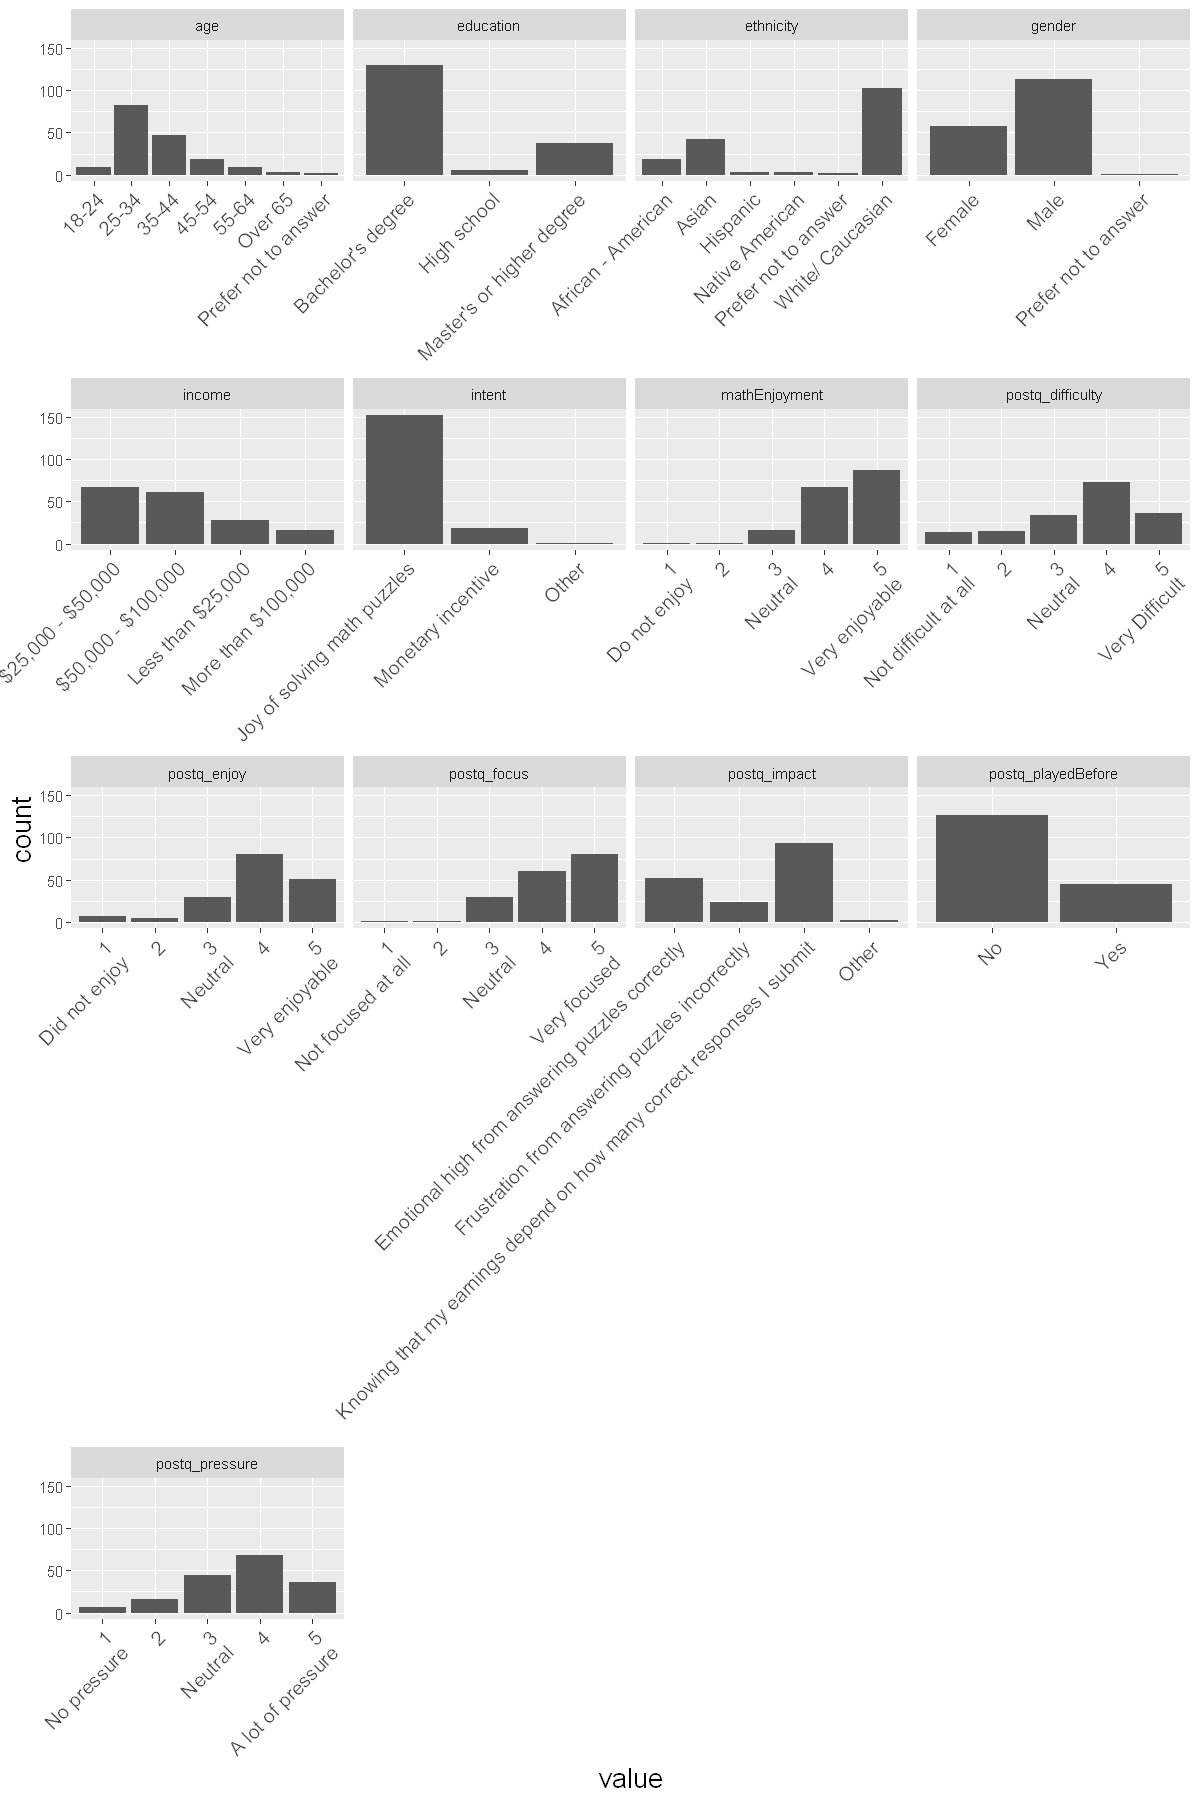

In [211]:
colsToPlot = c('gender', 'age', 'ethnicity', 'education', 'income', 'intent', 'mathEnjoyment',
                'postq_playedBefore', 'postq_enjoy', 'postq_difficulty', 'postq_focus', 'postq_pressure',
                'postq_impact'
               )

options(repr.plot.width=10, repr.plot.height=15)

ggplot(gather(cleanedData[, ..colsToPlot]), aes(value)) + 
    geom_bar() +
    facet_wrap(~key, scales = 'free_x') +
    theme(axis.text.x=element_text(angle=45,hjust=1, size=12))

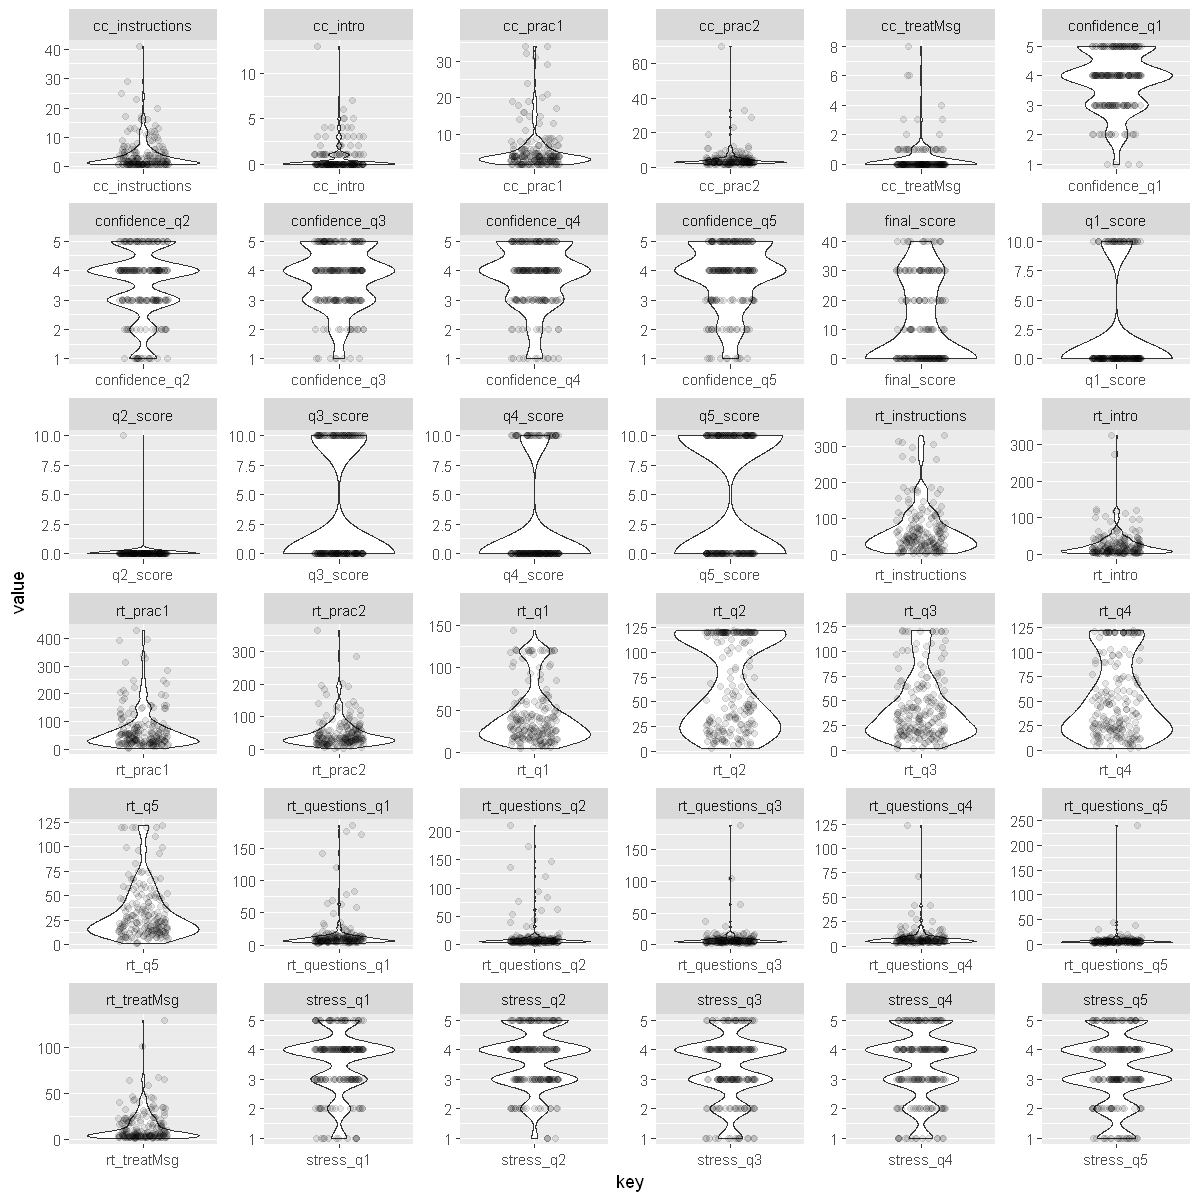

In [164]:
# histogram of all columns

options(repr.plot.width=10, repr.plot.height=10)

colsToPlot = c('rt_intro', 'cc_intro',
                'rt_instructions', 'cc_instructions',
                'rt_prac1', 'cc_prac1',
                'rt_prac2', 'cc_prac2',
                'rt_treatMsg', 'cc_treatMsg',
                'rt_q1', 'rt_questions_q1', 'stress_q1', 'confidence_q1',
                'rt_q2', 'rt_questions_q2', 'stress_q2', 'confidence_q2',
                'rt_q3', 'rt_questions_q3', 'stress_q3', 'confidence_q3',
                'rt_q4', 'rt_questions_q4', 'stress_q4', 'confidence_q4',
                'rt_q5', 'rt_questions_q5', 'stress_q5', 'confidence_q5',
                'q1_score', 'q2_score', 'q3_score', 'q4_score', 'q5_score', 'final_score'
               )
dataToPlot = data.table(sapply(cleanedData[, ..colsToPlot], as.numeric))

ggplot(gather(a), aes(x=key,y=value)) + 
    geom_violin() + 
    geom_jitter(position=position_jitter(0.2), alpha=0.1) +
    facet_wrap(~key, scales = 'free') 

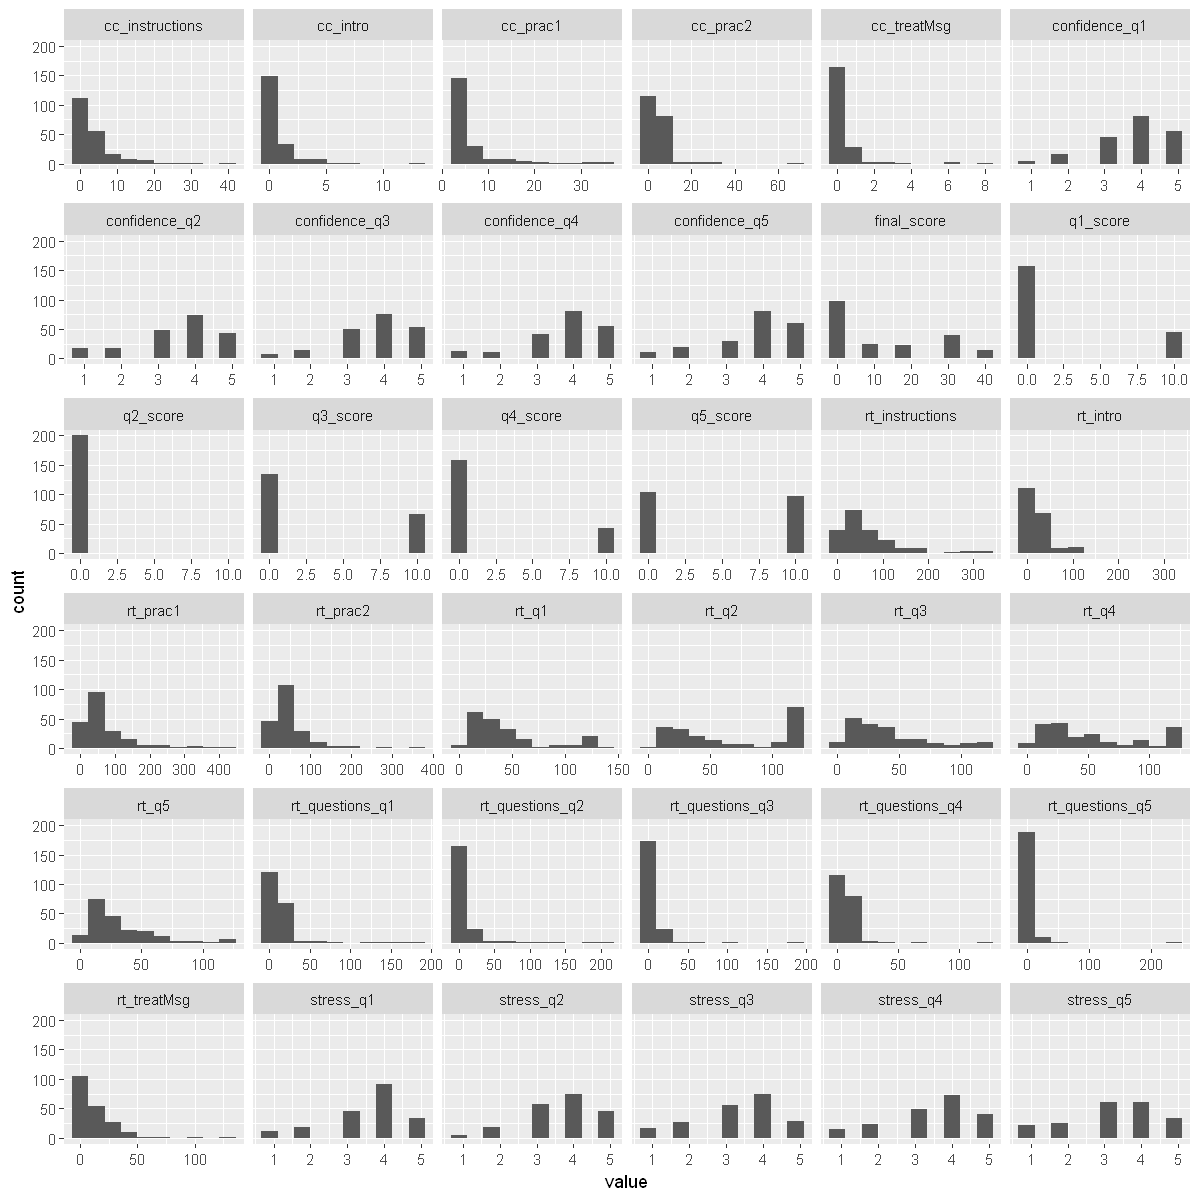

In [161]:
# histogram of all columns

options(repr.plot.width=10, repr.plot.height=10)

colsToPlot = c('rt_intro', 'cc_intro',
                'rt_instructions', 'cc_instructions',
                'rt_prac1', 'cc_prac1',
                'rt_prac2', 'cc_prac2',
                'rt_treatMsg', 'cc_treatMsg',
                'rt_q1', 'rt_questions_q1', 'stress_q1', 'confidence_q1',
                'rt_q2', 'rt_questions_q2', 'stress_q2', 'confidence_q2',
                'rt_q3', 'rt_questions_q3', 'stress_q3', 'confidence_q3',
                'rt_q4', 'rt_questions_q4', 'stress_q4', 'confidence_q4',
                'rt_q5', 'rt_questions_q5', 'stress_q5', 'confidence_q5',
                'q1_score', 'q2_score', 'q3_score', 'q4_score', 'q5_score', 'final_score'
               )
dataToPlot = data.table(sapply(cleanedData[, ..colsToPlot], as.numeric))

ggplot(gather(a), aes(value)) + 
    geom_histogram(bins = 10) + 
    facet_wrap(~key, scales = 'free_x')